Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Train shape: (5634, 19) Test shape: (1409, 19)
Churn distribution (train):
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Churn distribution (test):
 Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

Starting randomized search (this may take a while)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best CV AUC: 0.8478655802643917
Best params: {'clf__colsample_bytree': np.float64(0.9768807022739411), 'clf__gamma': np.float64(2.8164410892276965), 'clf__learning_rate': np.float64(0.12562495076197483), 'clf__max_depth': 4, 'clf__min_child_weight': 5, 'clf__n_estimators': 485, 'clf__subsample': np.fl

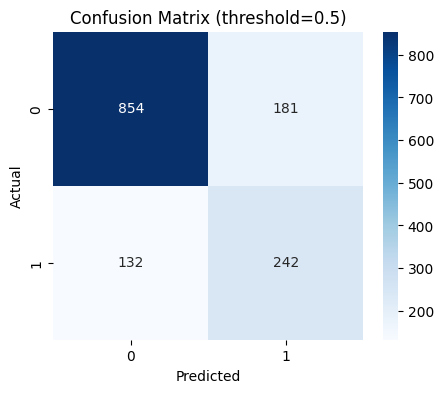

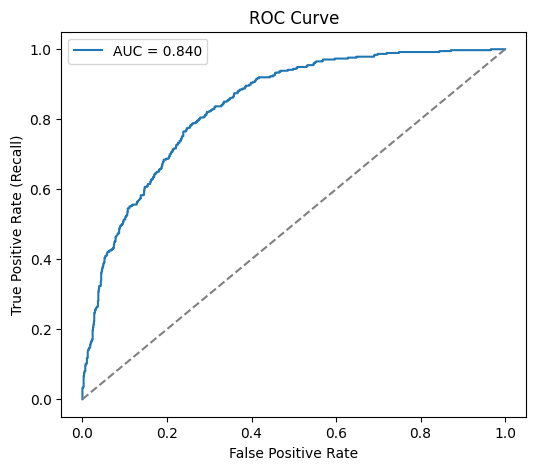

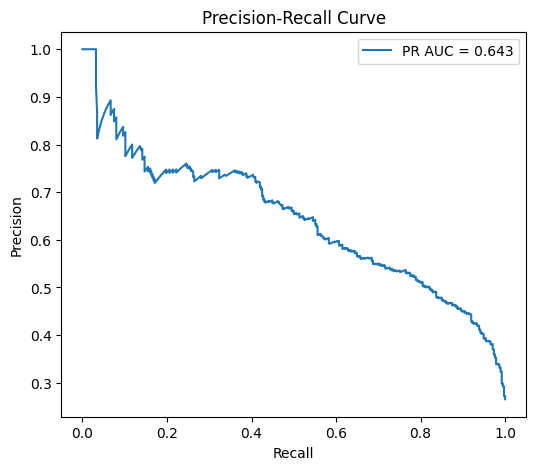

Best threshold by F1 on test: 0.36 with F1 = 0.630

Classification Report (best threshold):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



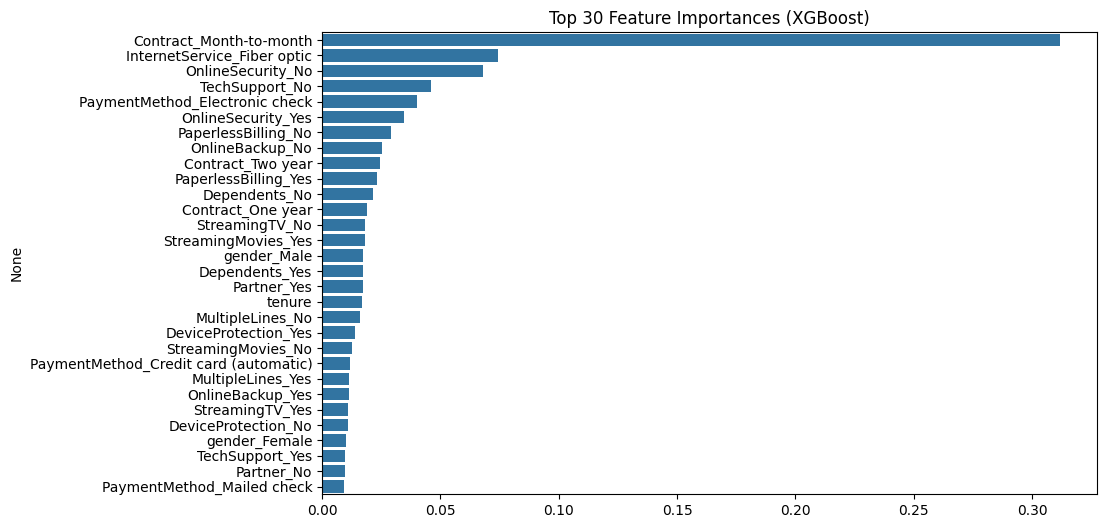

Saved best model to best_churn_xgb_pipeline.joblib

--- Summary ---
Best CV AUC: 0.8478655802643917
Test ROC-AUC: 0.8403433310082926
Best threshold (by F1 on test): 0.36
Saved model: best_churn_xgb_pipeline.joblib
Accuracy: 0.7778566359119943


In [5]:
# Advanced Churn Prediction Pipeline (SMOTE + Scaling + One-Hot + XGBoost + RandomizedSearchCV)
# Paste into a single Jupyter notebook cell and run.
# If a package is missing, uncomment the pip install lines and run them once.

# !pip install xgboost
# !pip install imbalanced-learn
# !pip install scikit-learn
# !pip install shap

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint, uniform

# --------- 1) Load data ----------
# Change the filename if needed
df = pd.read_csv("customer_churn_dataset.csv")  # replace with your filename

# Make a copy to avoid chained assignment warnings
df = df.copy()

# --------- 2) Basic cleaning ----------
# Drop customerID
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Convert TotalCharges to numeric (fix irregular strings), fill with median
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Ensure Churn is binary numeric
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

# Quick check (uncomment to inspect)
# display(df.head())
# display(df.info())

# --------- 3) Feature lists ----------
# Numeric features (treat SeniorCitizen as numeric)
num_features = [c for c in df.select_dtypes(include=['int64','float64']).columns if c != 'Churn']

# Categorical features (object dtype)
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# If there are binary-like 'Yes'/'No' columns as objects, they will be one-hot encoded appropriately
print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# --------- 4) Train/test split ----------
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Churn distribution (train):\n", y_train.value_counts(normalize=True))
print("Churn distribution (test):\n", y_test.value_counts(normalize=True))

# --------- 5) Preprocessing pipelines ----------
# Numeric transformer: scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# --------- FIXED CATEGORICAL TRANSFORMER ----------
try:
    # For sklearn >=1.2
    categorical_transformer = Pipeline(steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except:
    # For older sklearn versions
    categorical_transformer = Pipeline(steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# --------- 6) Model + SMOTE in imbalanced pipeline ----------
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', xgb)
])

# --------- 7) Hyperparameter space (Randomized Search) ----------
param_dist = {
    'clf__n_estimators': randint(100, 600),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__min_child_weight': randint(1, 10),
    'clf__gamma': uniform(0, 5)
}

# RandomizedSearchCV - optimize for AUC (robust for imbalanced)
rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# --------- 8) Fit (this will take some time depending on n_iter and data size) ----------
print("\nStarting randomized search (this may take a while)...")
rs.fit(X_train, y_train)

print("\nBest CV AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

# --------- 9) Evaluate on test set ----------
best_model = rs.best_estimator_

# Predict probabilities and labels
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)  # default threshold 0.5

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (threshold=0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------- 10) ROC Curve and Precision-Recall Curve ----------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, pr_thresh = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# --------- 11) Find best threshold for desired trade-off ----------
# Example: choose threshold that maximizes F1-score
from sklearn.metrics import f1_score

best_f1 = 0
best_t = 0.5
for t in np.linspace(0.1, 0.9, 81):
    preds = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Best threshold by F1 on test: {best_t:.2f} with F1 = {best_f1:.3f}")

# Show classification_report for best threshold
y_pred_best = (y_prob >= best_t).astype(int)
print("\nClassification Report (best threshold):")
print(classification_report(y_test, y_pred_best))

# --------- 12) Feature importance (mapped back to column names) ----------
# We need feature names after ColumnTransformer
# Get numeric feature names
num_names = num_features

# Get categorical feature names from OneHotEncoder
ohe = best_model.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
cat_ohe_names = []
if hasattr(ohe, 'get_feature_names_out'):
    cat_ohe_names = list(ohe.get_feature_names_out(cat_features))
else:
    # fallback
    for i, cat in enumerate(cat_features):
        uniq = preprocessor.named_transformers_['cat'].named_steps['ohe'].categories_[i]
        cat_ohe_names += [f"{cat}_{u}" for u in uniq]

feature_names = num_names + cat_ohe_names

# Extract feature importances from xgboost (clf is last step in pipeline)
clf = best_model.named_steps['clf']
try:
    importances = clf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:30]
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Top 30 Feature Importances (XGBoost)")
    plt.show()
except Exception as e:
    print("Could not plot feature importances:", e)

# --------- 13) Save the best model (optional) ----------
import joblib
joblib.dump(best_model, "best_churn_xgb_pipeline.joblib")
print("Saved best model to best_churn_xgb_pipeline.joblib")

# --------- 14) Quick summary print ----------
print("\n--- Summary ---")
print("Best CV AUC:", rs.best_score_)
print("Test ROC-AUC:", roc_auc)
print("Best threshold (by F1 on test):", best_t)
print("Saved model: best_churn_xgb_pipeline.joblib")
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

